<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/CNN_2_class_PyTorch_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Общие настройки
*  импорт библиотек
*  функция обучения
*  функция оценки модели
*  функции отрисовки графиков (2 шт)
*  засекание времени





####Импорт необходимых библиотек

In [1]:
import torch
from torch import nn

#  Импорт библиотек для загрузки данных
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


#  Импорт библиотек для отрисовки графиков
import matplotlib.pyplot as plt
from PIL import Image
import random #  для вывода случайных изображений

#  Импорт библиотеки для вывода полосы прогресса
from tqdm.auto import tqdm
#  Импорт библиотеки для таймера
from timeit import default_timer as timer 


import numpy as np

import requests
import zipfile
from pathlib import Path
import os

from typing import Tuple, Dict, List

from tqdm.auto import tqdm

####Функция по обучению модели

In [2]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

####Функция по оценке модели модели

In [3]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

####Train loop !!!

---



In [4]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    """
      Возвращает словарь train_loss, train_acc, test_loss, test_acc
    """
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

####Предсказание

In [5]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device) 

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)      

####Функции вывода графиков с изображениями

In [6]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  """
    Строит набор из n графиков изображений, расположенных в папке image_path и
    обработанных преобразованием transforms
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Оригинальный \nРазмер: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0) 
      ax[1].imshow(transformed_image) 
      ax[1].set_title(f"Преобразованный \nРазмер: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Метка: {image_path.parent.stem}")

In [7]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

####Функции вывода графиков с результатами обучения

In [8]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

####Функция засекания времени работы модели (function model execution time)

####Установка устройства `"cuda"`

In [9]:
device = "cuda" if torch.cuda.is_available else "cpu"

####Загрузка датасета

In [10]:
# подключение гугл диска, на котором хранится zip-архив с датасетом
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
#  Установить пути к папке с данными. 
image_path = Path('/content/WineYardDataset')

if image_path.is_dir():
  print(f"{image_path} папка для распаковки датасета существует")
else:
  print(f"{image_path} не существует, создана новая папка ...")
  image_path.mkdir(parents = True, exist_ok = True)

  #  здесь могла бы быть загрузка файла, но файл итак на гугл диске, поэтому
  #  можно дописать в случае необходимости и библиотеки request

  #  Распаковка архива
  with zipfile.ZipFile("/content/drive/MyDrive/Виноградники/Dataset.zip", "r") as zip_ref:
    print("Распаковка...")
    zip_ref.extractall(image_path)




/content/WineYardDataset не существует, создана новая папка ...
Распаковка...


In [12]:
image_path = Path('/content/WineYardDataset/Dataset')

In [13]:
##  Другой способ распаковать архив. Проще. Быстрее. Понятнее
##  !unzip /content/drive/MyDrive/Виноградники/Dataset.zip

In [14]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/WineYardDataset/Dataset'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/train'.
There are 0 directories and 8484 images in '/content/WineYardDataset/Dataset/train/1'.
There are 0 directories and 3085 images in '/content/WineYardDataset/Dataset/train/2'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/test'.
There are 0 directories and 1212 images in '/content/WineYardDataset/Dataset/test/1'.
There are 0 directories and 442 images in '/content/WineYardDataset/Dataset/test/2'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/val'.
There are 0 directories and 2424 images in '/content/WineYardDataset/Dataset/val/1'.
There are 0 directories and 881 images in '/content/WineYardDataset/Dataset/val/2'.


Дальше посмотрим на структуру данных и не будем торопиться. 
Во-первых, выведем на экран случайное изображение

Random image path: /content/WineYardDataset/Dataset/train/1/frame_8877.jpg
Image class: 1
Image height: 360
Image width: 360


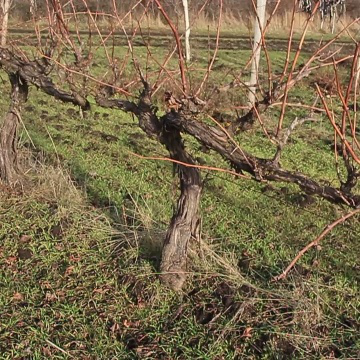

In [15]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
# 3. Получите класс изображения по имени пути (класс изображения - это имя каталога, в котором хранится изображение)
image_class = random_image_path.parent.stem
image = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")
image

**ИЛИ** тоже самое с помощью 

```
 matplotlib.pyplot.imshow()
```
но сначала переведем в массив `numpy`.
Предпочтительнее matplotlib


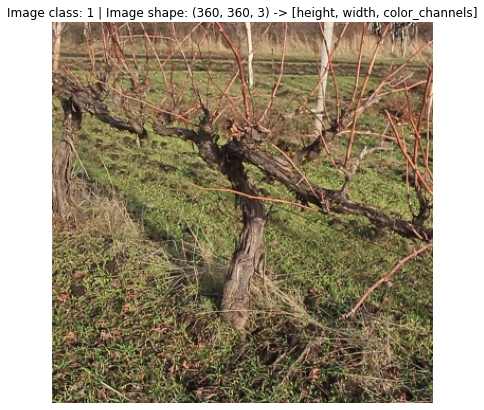

In [16]:
image_as_array = np.array(image)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

###Первая модель
*Описание модели*

####Трансформация данных
Не забыть про аугментацию (augmentation)


[Смотреть здесь](https://www.learnpytorch.io/04_pytorch_custom_datasets/#3.-Transforming-data)

In [17]:
data_transformation = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() #обращает значения пикселей от 0 до 255 в значения от 0.0 до 1.0
])

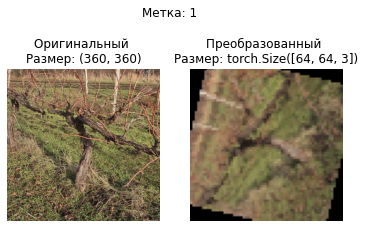

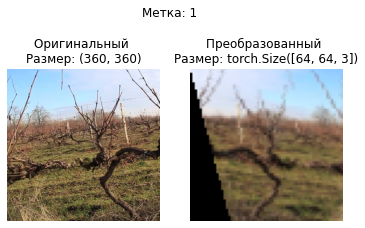

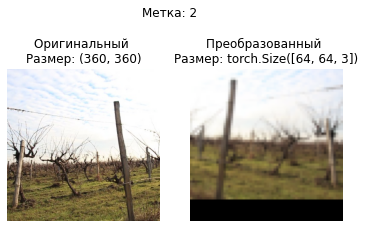

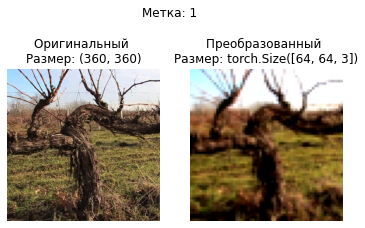

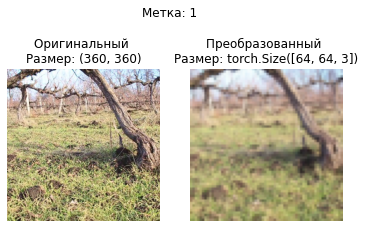

In [18]:
plot_transformed_images(image_paths=image_path_list,
                        transform = data_transformation,
                        n = 5)

####Загрузка датасета в DataLoader

In [19]:
train_dir = image_path / "train"
test_dir = image_path / "test"


In [20]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transformation,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transformation)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 11569
    Root location: /content/WineYardDataset/Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1654
    Root location: /content/WineYardDataset/Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [21]:
class_names = train_data.classes
class_names
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'1': 0, '2': 1}

In [22]:
len(train_data), len(test_data)

(11569, 1654)

Оригинальная форма: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Трансформированная форма: torch.Size([64, 64, 3]) -> [height, width, color_channels]


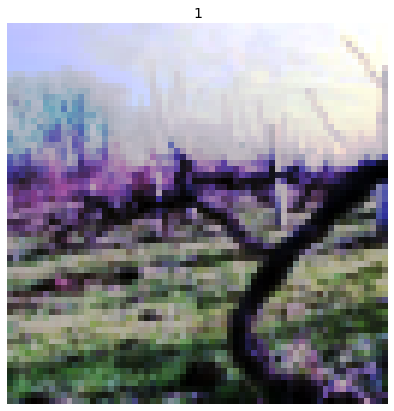

In [23]:
#  Первое изображение в датасете
image, label = train_data[0][0], train_data[0][1]
#  CHW -> HWC
img_permute = image.permute(1, 2, 0)


print(f"Оригинальная форма: {image.shape} -> [color_channels, height, width]")
print(f"Трансформированная форма: {img_permute.shape} -> [height, width, color_channels]")

#  Вывод изображения
plt.figure(figsize=(10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [24]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # как много кадров в батче
                              num_workers=NUM_WORKERS, # как много процессов использовать для работы
                              shuffle=True) # перемешать данные

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data
print(f"Создание DataLoaders с batch: {BATCH_SIZE} и workers: {NUM_WORKERS}.")
train_dataloader, test_dataloader

Создание DataLoaders с batch: 32 и workers: 2.


(<torch.utils.data.dataloader.DataLoader at 0x7fe14087cac0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe140880e20>)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size - это первое число
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


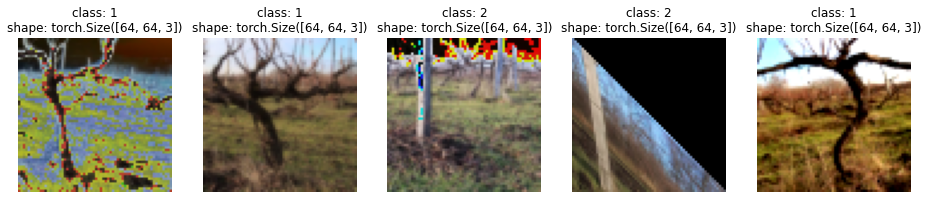

In [26]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


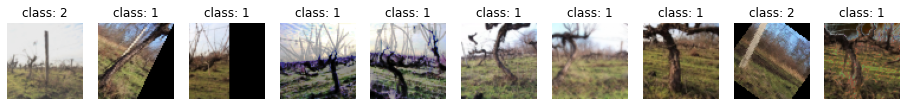

In [27]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

####Описание слоев модели и инициализация модели
Начать с TINY

In [28]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

Проверка модели

In [29]:
#Сначала вытащим один батч
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Форма одного изображения: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))
  
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Форма одного изображения: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0513, 0.0556]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4989, 0.5011]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0


####Получение информации о созданной модели

In [30]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

####Назначение оптимизатора (optimizer) и функции потерь (loss_fn) и Цикл обучения

In [32]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5033 | train_acc: 0.7743 | test_loss: 0.4681 | test_acc: 0.8148
Epoch: 2 | train_loss: 0.4118 | train_acc: 0.8256 | test_loss: 0.3830 | test_acc: 0.8406
Epoch: 3 | train_loss: 0.3610 | train_acc: 0.8434 | test_loss: 0.3317 | test_acc: 0.8692
Epoch: 4 | train_loss: 0.3367 | train_acc: 0.8602 | test_loss: 0.2917 | test_acc: 0.8766
Epoch: 5 | train_loss: 0.3011 | train_acc: 0.8711 | test_loss: 0.2993 | test_acc: 0.8669
Total training time: 280.455 seconds


In [33]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

####Вывод графика обучения

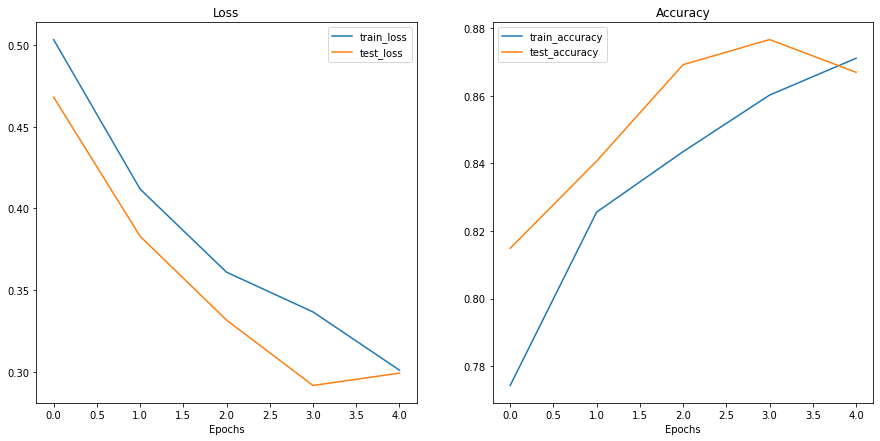

In [34]:
plot_loss_curves(model_0_results)

###Тестирование

####Вывод на случайном изображении из папки val (изображение и метка)
image, label


*добавить случайный выбор файла*

In [35]:
custom_image_path = image_path / "val/1/frame_10834.jpg" #  Class 1 - Winelose
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")


Custom image tensor:
tensor([[[0.6902, 0.6902, 0.6902,  ..., 0.9843, 0.9804, 0.7843],
         [0.6863, 0.6824, 0.6863,  ..., 0.9647, 0.9961, 0.9333],
         [0.6824, 0.6745, 0.6824,  ..., 0.9647, 0.9882, 1.0000],
         ...,
         [0.2118, 0.2863, 0.2784,  ..., 0.4275, 0.2235, 0.1294],
         [0.3294, 0.3176, 0.2549,  ..., 0.4784, 0.2471, 0.1216],
         [0.3176, 0.3412, 0.2549,  ..., 0.4941, 0.3961, 0.1882]],

        [[0.8078, 0.8078, 0.8078,  ..., 0.9882, 0.9804, 0.7843],
         [0.8039, 0.8078, 0.8039,  ..., 0.9686, 0.9922, 0.9333],
         [0.8078, 0.8039, 0.8078,  ..., 0.9608, 0.9765, 0.9961],
         ...,
         [0.1765, 0.2471, 0.2353,  ..., 0.3608, 0.1529, 0.0588],
         [0.2824, 0.2784, 0.2118,  ..., 0.3961, 0.1647, 0.0471],
         [0.2706, 0.2941, 0.2118,  ..., 0.4000, 0.3137, 0.1059]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9882, 0.7922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 1.0000, 0.9412],
         [1.0000, 1.0000, 1.0000,  ..

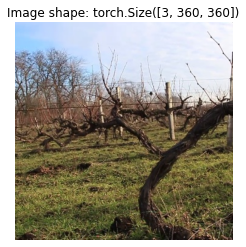

In [36]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [37]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 360, 360])
New shape: torch.Size([3, 64, 64])


In [38]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [39]:
custom_image_pred

tensor([[ 2.0764, -2.1127]], device='cuda:0')

In [40]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 2.0764, -2.1127]], device='cuda:0')
Prediction probabilities: tensor([[0.9851, 0.0149]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [41]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'1'

In [42]:
custom_image_pred_probs

tensor([[0.9851, 0.0149]], device='cuda:0')

####"*Visualize, visualize, visualize!*"
#### Выполнение случайных прогнозов с помощью наилучшей модели

In [44]:
def plot_random_test_image(model: torch.nn.Module,
                           seed = 42,
                           n = 12,
                           test_data: torch.utils.data.dataset.Dataset = test_data,
                           device = "cpu"):
  random.seed(seed)
  test_samples = []
  test_labels = []
  for sample, label in random.sample(list(test_data), k=n):
      test_samples.append(sample)
      test_labels.append(label)

  pred_probs= make_predictions(model=model, data=test_samples, device=device)

  pred_classes = pred_probs.argmax(dim=1)

  plt.figure(figsize = (12, 12))

  nrows = 4
  ncols = 3

  for i in range(len(test_samples)):
    plt.subplot(nrows, ncols, i+1)
    img, label = test_samples[i][0], test_samples[i][1]
    plt.imshow(img, cmap = "inferno")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
      plt.axis(False)



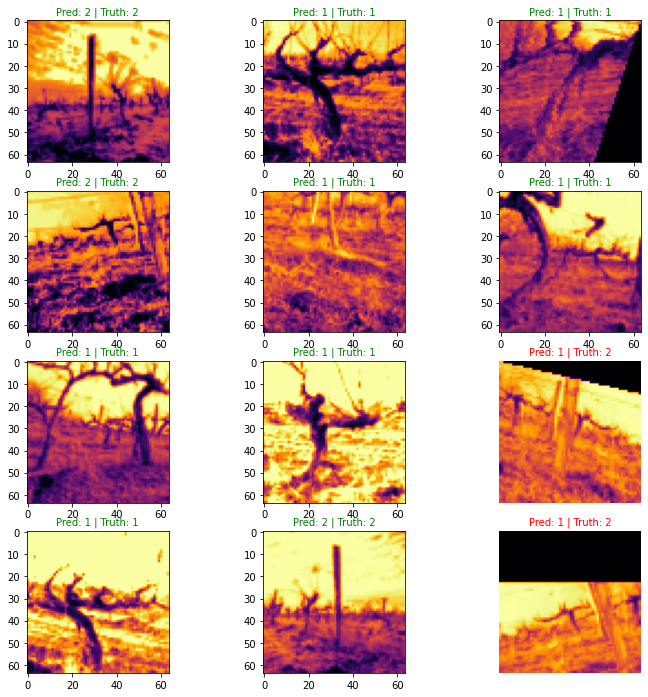

In [46]:
plot_random_test_image(model_0, seed = 42, n = 12, test_data = test_data,  device = device)

###Сравнение результатов моделей

####Model_0 10 эпох

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model_1 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

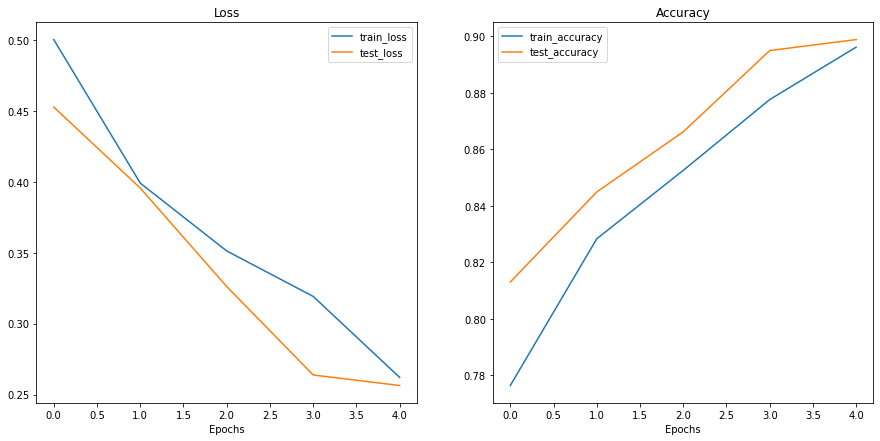

In [53]:
plot_loss_curves(model_0_results)

####Подбор гиперпараметров (hyperparameter tuna)

Официальный туториал [здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
